In [1]:
%matplotlib inline

import numpy as np
from scipy import stats
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd

# To use gptools with Python 3, clone from GitHub repository 
#   https://github.com/markchil/gptools 
# and install with 'pip install .' from inside repo. 
import gptools  


In [2]:
mpl.rcParams['text.usetex'] = True
mpl.rcParams['figure.dpi'] = 130
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['xtick.direction'] = 'in'
mpl.rc('savefig', transparent=False, bbox='tight', pad_inches=0.05, format='pdf')

In [3]:
color_68 = 'darkgrey'   # color for 1 sigma bands
color_95 = 'lightgrey'  # color for 2 sigma bands

def curve_plus_bands_plot(ax, x, y, std, 
                          _color_68=color_68, _color_95=color_95, **kwargs):
    """
    Plot y vs. x with one sigma and two sigma bands based on std on axis ax.
     Add any other keyword pairs to style the main curve.
    """
    ax.plot(x, y, **kwargs)
    ax.fill_between(x, y + 2*std, y - 2*std, color=_color_95)
    ax.fill_between(x, y + std, y - std, color=_color_68)


# Standard Case

We have data and would like to find a function that best captures the relationship between the inputs and outputs.
A popular nonparametric tool for regression is a Gaussian process (GP).
One of the neat things about a GP is that you automatically get uncertainty quantification along with the line of best fit.
But what is less well known is that it also provides derivatives of the best fit line, and corresponding uncertainty estimates, for free!

## Fitting a function f(x)

Let's check out how it works. Start by creating some data with noise.

In [4]:
x = np.linspace(0, 1, 20)
x_star = np.linspace(0, 1, 100)

#np.random.seed(1)
np.random.seed(None)  # different data every time

f = x ** 2
std = 0.1
y = f + stats.norm(scale=std).rvs(len(x))

Now plot the true line and the data we will use to fit our curve.

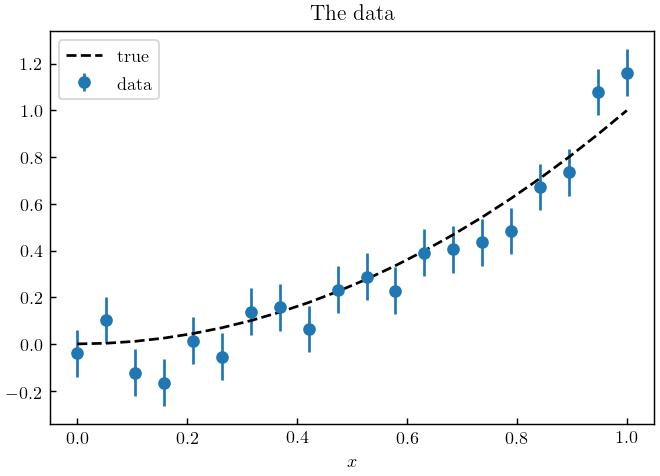

In [5]:
plt.plot(x, f, c='k', ls='--', label='true')
plt.errorbar(x, y, std, ls='', marker='o', label='data')
plt.xlabel('$x$')
plt.title("The data")
plt.legend();

To use a GP, we need to convert the 1d `x` input into an `NxD` matrix (since GPs can live in a `D` dimensional space, in general).
This is a `D=1` dimensional space in this example.

In [6]:
X = x[:, None]
X_star = x_star[:, None]

Begin by creating the kernel, which quantifies the correlation structure (smoothness properties) of the curves.
Then feed the kernel into a GP object, and fit it to the data we plotted above.
The radial basis function kernel (i.e., the Squared Exponential) has two hyperparameters that it depends on: the marginal variance and length scale.
Let's let the data decide which hyperparameters provide the best fit, via optimization.

In [7]:
# rbf_kernel = gptools.SquaredExponentialKernel(initial_params=[1,1], fixed_params=[True, True])
rbf_kernel = gptools.SquaredExponentialKernel(initial_params=[1,1], param_bounds=[(1e-5, 2), (1e-2, 2)])
gp = gptools.GaussianProcess(rbf_kernel)
gp.add_data(X, y, err_y=std)
gp.optimize_hyperparameters(max_tries=3)

(     fun: 28.56945318585398
      jac: array([0.00129628, 0.0087502 ])
  message: 'Optimization terminated successfully.'
     nfev: 37
      nit: 8
     njev: 8
   status: 0
  success: True
        x: array([0.73385734, 0.34064445]), 8)

That's it! Now we can get the curve of best fit and its uncertainty.

In [8]:
y_star, std_star = gp.predict(X_star, return_std=True)

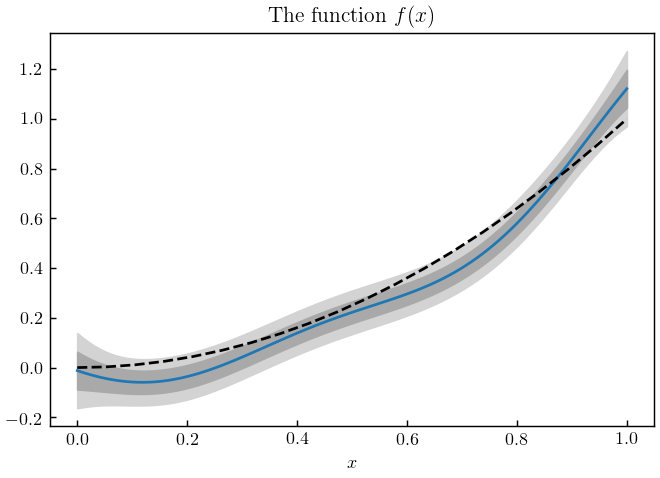

In [9]:
fig, ax = plt.subplots(1, 1)
curve_plus_bands_plot(ax, x_star, y_star, std_star)
ax.plot(x, f, color='black', ls='--')
ax.set_title("The function $f(x)$")
ax.set_xlabel('$x$');

## Estimating the derivative f'(x)

Since our function is simple, we can take its derivative analytically and compare to our approximation.

In [10]:
f_prime = 2 * x

`GPTools` allows for predicting derivatives very easily! Just use `n=1` in the `predict` method to compute the first derivative.

In [11]:
y_prime_star, std_prime_star = gp.predict(X_star, n=1, return_std=True)

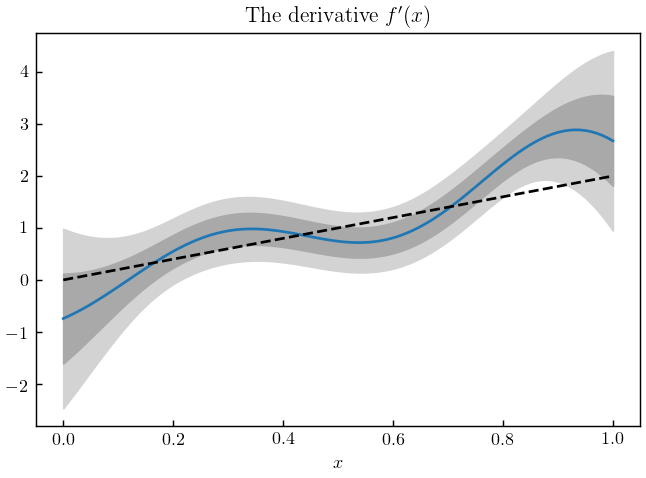

In [12]:
fig, ax = plt.subplots(1, 1)
curve_plus_bands_plot(ax, x_star, y_prime_star, std_prime_star)
ax.plot(x, f_prime, color='black', ls='--')
ax.set_title("The derivative $f'(x)$")
ax.set_xlabel('$x$');

# Nuclear Matter Application

Our specific use case is similar to the example above: we fit a GP to data, in this case from a physics simulation.
But there is one additional source of uncertainty from the theory error. This will also involve us creating our own custom GP kernel!

Start again by getting some data.

In [13]:
df = pd.read_csv('../data/all_matter_data.csv')
# Convert differences to total prediction at each MBPT order
mbpt_orders = ['Kin', 'MBPT_HF', 'MBPT_2', 'MBPT_3', 'MBPT_4']
df[mbpt_orders] = df[mbpt_orders].apply(np.cumsum, axis=1)
# 'total' is now unnecessary. Remove it.
df.pop('total');

In [14]:
orders = np.array([0, 2, 3, 4])
# body = 'NN-only'
body = 'NN+3N'
Lambda = 450
fits = {450: [1, 7], 500: [4, 10]}
train1 = slice(None, None, 5)
valid1 = slice(2, None, 5)
# valid1 = np.array([i % 5 != 0 for i in range(len())])
[fit_n2lo, fit_n3lo] = fits[Lambda]

excluded = np.array([1])

savefigs = False

mask_fit = np.isin(df['fit'], fits[Lambda]) | np.isnan(df['fit'])

mask1 = \
    (df['Body'] == body) & \
    mask_fit & \
    (df['Lambda'] == Lambda)


# df_fit = df[mask_fit]
df_n = df[mask1 & (df['x'] == 0)]
df_s = df[mask1 & (df['x'] == 0.5)]

kf_n = df_n[df_n['OrderEFT'] == 'LO']['kf'].values
kf_s = df_s[df_s['OrderEFT'] == 'LO']['kf'].values
density = df_n[df_n['OrderEFT'] == 'LO']['n'].values
kf_d = kf_n.copy()

# valid1 = np.arange(len(kf_n)) % 5 != 0

Kf_n = kf_n[:, None]
Kf_s = kf_s[:, None]
Kf_d = kf_d[:, None]

y_n = np.array([df_n[df_n['OrderEFT'] == order]['MBPT_4'].values for order in df_n['OrderEFT'].unique()]).T
y_s = np.array([df_s[df_s['OrderEFT'] == order]['MBPT_4'].values for order in df_s['OrderEFT'].unique()]).T
y_d = y_n - y_s

In [15]:
y_s.shape

(17, 4)

Visualize it.

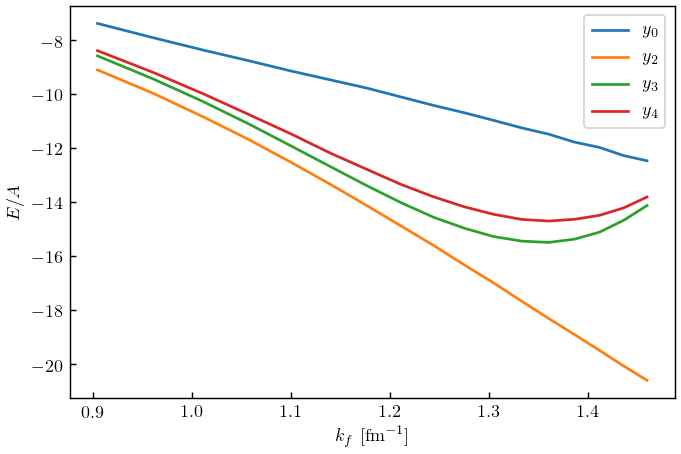

In [16]:
fig, ax = plt.subplots(1, 1)
for i, n in enumerate(orders):
    ax.plot(kf_s, y_s[:, i], label=fr'$y_{n}$')
ax.legend()
ax.set_xlabel(r'$k_f$ [fm$^{-1}$]')
ax.set_ylabel(r'$E/A$');

The kernel for our GP convergence model is not a simple RBF, it must be multiplied by factors related to the converges of the EFT:

\begin{align}
    \kappa(x, x';\bar c, \ell) = y_{\text{ref}}(x)y_{\text{ref}}(x') \frac{[Q(x)Q(x')]^{k+1}}{1-Q(x)Q(x')} \bar c^2 r(x,x';\ell)
\end{align}

where $\bar c^2 r(x,x';\ell)$ is the RBF kernel used above.
GPTools can handle products of kernels, so we just need to create a kernel object that represents the prefactor above.
I'm still not completely sure how to make a truly compatible kernel object, but the code below seems to do the trick.

In [17]:
class CustomKernel(gptools.Kernel):
    """A Custom GPTools kernel that wraps an arbitrary function f with a compatible signature
    
    Parameters
    ----------
    f : callable
        A positive semidefinite kernel function that takes f(Xi, Xj, ni, nj) where ni and nj are
        integers for the number of derivatives to take with respect to Xi or Xj. It should return
        an array of Xi.shape[0]
    *args
        Args passed to the Kernel class
    **kwargs
        Kwargs passed to the Kernel class
    """
    
    def __init__(self, f, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.f = f

    def __call__(self, Xi, Xj, ni, nj, hyper_deriv=None, symmetric=False):
        return self.f(Xi, Xj, int(np.unique(ni)[0]), int(np.unique(nj)[0]))

We need to take arbitrary numbers of derivatives. Humans can make mistakes, let `SymPy` handle it.

In [18]:
from sympy import symbols, diff, sqrt, lambdify

def kernel_scale_sympy(lowest_order=4, highest_order=None):
    """Creates a sympy object that is the convergence part of the GP kernel
    
    Parameters
    ----------
    lowest_order
    highest_order
    """
    k_f1, k_f2, y_ref, Lambda_b, = symbols('k_f1 k_f2 y_ref Lambda_b')
    hbar_c = 200
    Q1 = hbar_c * k_f1 / Lambda_b
    Q2 = hbar_c * k_f2 / Lambda_b
    num = (Q1 * Q2)**(lowest_order)
    if highest_order is not None:
        num = num - (Q1 * Q2)**highest_order
    kernel_scale = y_ref**2 * num / (1 - Q1*Q2)
    return k_f1, k_f2, Lambda_b, y_ref, kernel_scale

def eval_kernel_scale(Xi, Xj=None, ni=None, nj=None, breakdown=600, ref=16, lowest_order=4, highest_order=None):
    """Creates a matrix for the convergence part of the GP kernel.
    Compatible with the CustomKernel class signature.
    
    Parameters
    -----------
    Xi
    Xj
    ni
    nj
    breakdown
    ref
    lowest_order
    highest_order
    """
    if ni is None:
        ni = 0
    if nj is None:
        nj = 0
    k_f1, k_f2, Lambda_b, y_ref, kernel_scale = kernel_scale_sympy(
        lowest_order=lowest_order, highest_order=highest_order
    )
    expr = diff(kernel_scale, k_f1, ni, k_f2, nj)
    f = lambdify((k_f1, k_f2, Lambda_b, y_ref), expr, "numpy")
    if Xj is None:
        Xj = Xi
    K = f(Xi, Xj, breakdown, ref)
    K = K.astype('float')
    return np.squeeze(K)

Finally, we can create the kernel objects for our GP interpolation and derivatives. Assume some values for the hyperparameters, these would come from our convergence analysis of the observable coefficients.

In [19]:
from functools import partial

k_max = 4
eval_kernel_lower = partial(eval_kernel_scale, lowest_order=0, highest_order=k_max)
eval_kernel_upper = partial(eval_kernel_scale, lowest_order=k_max+1)

matter_rbf_kernel = gptools.SquaredExponentialKernel(
    initial_params=[1,1], fixed_params=[True, True])

kernel_lower = CustomKernel(eval_kernel_lower) * matter_rbf_kernel
kernel_upper = CustomKernel(eval_kernel_upper) * matter_rbf_kernel

In [20]:
kf_s_all = np.linspace(kf_s[0], kf_s[-1], 50)
Kf_s_all = kf_s_all[:, None]

Begin by interpolating the data points we plotted above. This does not include truncation error yet. Also compute its derivative as before.

In [21]:
gp_lower = gptools.GaussianProcess(kernel_lower)
gp_lower.add_data(Kf_s[:], y_s[:,-1], err_y=1e-5)

y_s_star, std_s_star = gp_lower.predict(Kf_s_all, return_std=True)
y_s_star_prime, std_s_star_prime = gp_lower.predict(Kf_s_all, n=1, return_std=True)

But now we can create the additional source of uncertainty due to EFT truncation.
Create both the error term for the interpolant and for its derivative.

In [22]:
zero_d = np.zeros(Kf_s_all.shape, dtype=int)
one_d = np.ones(Kf_s_all.shape, dtype=int)
std_upper_star = np.sqrt(kernel_upper(Kf_s_all, Kf_s_all, ni=zero_d, nj=zero_d))
std_upper_star_prime = np.sqrt(kernel_upper(Kf_s_all, Kf_s_all, ni=one_d, nj=one_d))

std_total_star = std_s_star + std_upper_star
std_total_star_prime = std_s_star_prime + std_upper_star_prime 

Let's see how we did. Error bands represent 2 standard deviations.
The left plot shows the interpolant alone, with error bands that are so small they can't be seen.
The right plot is the same as the left, except truncation bands are added.

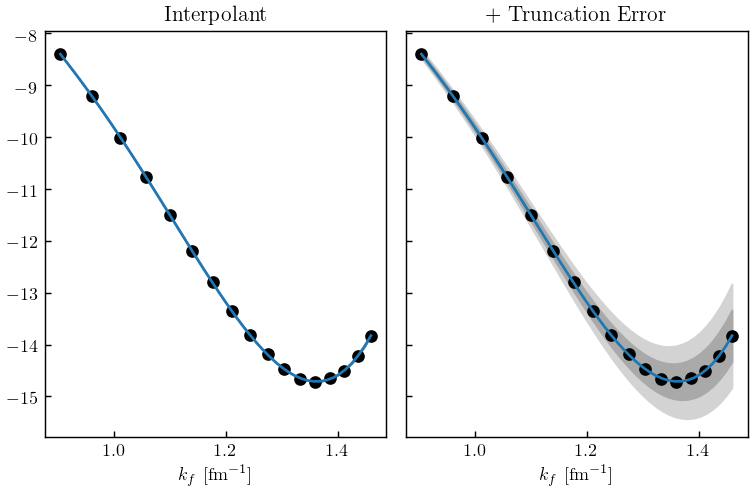

In [23]:
fig, axes = plt.subplots(1, 2, sharey=True, sharex=True)
ax1, ax2 = axes
ax1.plot(kf_s, y_s[:, -1], ls='', marker='o', c='k');
curve_plus_bands_plot(ax1, kf_s_all, y_s_star, std_s_star)
ax1.set_title('Interpolant')
ax1.set_xlabel(r'$k_f$ [fm$^{-1}$]')

ax2.plot(kf_s, y_s[:, -1], ls='', marker='o', c='k');
curve_plus_bands_plot(ax2, kf_s_all, y_s_star, std_total_star)
ax2.set_title('+ Truncation Error')
ax2.set_xlabel(r'$k_f$ [fm$^{-1}$]')
fig.tight_layout()

Plot the derivatives with respect to $k_{f}$ similarly

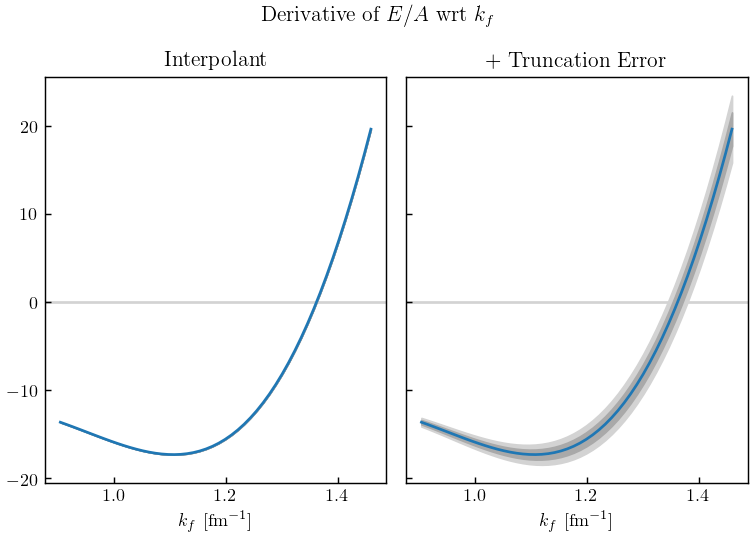

In [24]:
fig, axes = plt.subplots(1, 2, sharey=True, sharex=True)
ax1, ax2 = axes

curve_plus_bands_plot(ax1, kf_s_all, y_s_star_prime, std_s_star_prime)
ax1.axhline(0, 0, 1, c=color_95, zorder=0)
ax1.set_title('Interpolant')
ax1.set_xlabel(r'$k_f$ [fm$^{-1}$]')

curve_plus_bands_plot(ax2, kf_s_all, y_s_star_prime, std_total_star_prime)
ax2.axhline(0, 0, 1, c=color_95, zorder=0)
ax2.set_title('+ Truncation Error')
ax2.set_xlabel(r'$k_f$ [fm$^{-1}$]')

fig.suptitle('Derivative of $E/A$ wrt $k_{f}$', y=1.05)
fig.tight_layout()

Nice! This is, up to some easily handled scaling factors, the pressure! With truncation errors!